In [1]:
# GSE161801_01.Preproc_v01
# Alberto Bejarano (2024)

In [2]:
# https://pmc.ncbi.nlm.nih.gov/articles/PMC7779747/
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE279781
# https://www.cell.com/iscience/pdf/S2589-0042(24)02796-2.pdf

In [3]:
import sys
variables = {var: sys.getsizeof(obj) / (1024**2)  # List variables with their memory size
             for var, obj in globals().items() if not var.startswith("__")}
for var, size in variables.items():
    print(f"{var}: {size:.2f} MB", end=" ")
    
print([var for var in dir() if not var.startswith('__')])
%reset -f

_ih: 0.00 MB _oh: 0.00 MB _dh: 0.00 MB In: 0.00 MB Out: 0.00 MB get_ipython: 0.00 MB exit: 0.00 MB quit: 0.00 MB open: 0.00 MB _: 0.00 MB _i: 0.00 MB _ii: 0.00 MB _iii: 0.00 MB _i1: 0.00 MB _i2: 0.00 MB _i3: 0.00 MB sys: 0.00 MB ['In', 'Out', '_', '_dh', '_i', '_i1', '_i2', '_i3', '_ih', '_ii', '_iii', '_oh', 'exit', 'get_ipython', 'open', 'quit', 'size', 'sys', 'var', 'variables']


In [4]:
import time; code_start = time.time()
#from datetime import datetime; print(datetime.now().strftime("%B %d, %Y %H:%M:%S"))

In [5]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [6]:
import warnings; warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [7]:
#!conda info --envs

In [8]:
import pandas as pd;
#pd.options.display.float_format = ' {:.3f}' .format
pd.options.display.max_columns = 200
#         .         .         .         .         .         .         .         .
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.pyplot import rc_context
#from adjustText import adjust_text
import matplotlib.pyplot as plt
import matplotlib.transforms
import autograd.numpy as np
from scipy import stats
import seaborn as sns; sns.__version__
import anndata as ad
from IPython.display import Audio, display

In [9]:
import scipy.io as sio
import scanpy as sc
import scipy
import gzip
import os, gc

In [10]:
sc.settings.set_figure_params(scanpy=True, dpi=150, dpi_save=150, color_map='coolwarm',facecolor='white',
                             format='png', transparent=False, frameon=False, vector_friendly=True, fontsize=14)
sc.settings.verbosity = 0    # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.logging.print_header()

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


In [11]:
annotations_path  = '../../data/GSE279781/GSE279781__annotations.csv.gz'
features_path     = '../../data/GSE279781/GSE279781_features.tsv.gz'
barcodes_path     = '../../data/GSE279781/GSE279781_barcodes.tsv.gz'
#         .         .         .         .         .         .         .         .
scdata_path          = '../../data/GSE279781/GSE279781_matrix.mtx.gz'
HVG_h5ad_file_path   = '../../data/GSE279781/GSE279781_HVG.h5ad'
#adata = sc.read_mtx(data_path + 'matrix.mtx.gz'); adata

In [12]:
metadata = pd.read_csv(barcodes_path, header=0, sep=',', quotechar='"', on_bad_lines = "warn")
metadata.sample(2)

,AAACGGGAGCAATATG-1
22872,GGAAAGCGTAGGCTGA-6
75305,AGCGTATCAGGTCCAC-14


In [13]:
%%time
adata = sc.read_mtx(scdata_path)

CPU times: total: 1min 34s
Wall time: 1min 34s


In [14]:
print(f"AnnData shape:         {adata.shape}")
print(f"Number of cells (obs): {adata.n_obs}")
print(f"Number of genes (var): {adata.n_vars}")

AnnData shape:         (36601, 150628)
Number of cells (obs): 36601
Number of genes (var): 150628


In [15]:
print(adata.var.head())

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


In [16]:
print(adata.obs.head())

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


In [17]:
adata = adata.transpose()

In [18]:
adata.X

<150628x36601 sparse matrix of type '<class 'numpy.float32'>'
	with 96093358 stored elements in Compressed Sparse Column format>

In [19]:
adata.obs_names = [f"Cell_{i:d}" for i in range(adata.n_obs)];  print(adata.obs_names[:6])
adata.var_names = [f"Gene_{i:d}" for i in range(adata.n_vars)]; print(adata.var_names[:6])

Index(['Cell_0', 'Cell_1', 'Cell_2', 'Cell_3', 'Cell_4', 'Cell_5'], dtype='object')
Index(['Gene_0', 'Gene_1', 'Gene_2', 'Gene_3', 'Gene_4', 'Gene_5'], dtype='object')


In [20]:
gene_data = pd.read_csv(features_path, header=None, sep='\t', quotechar='"', skiprows=0, on_bad_lines='warn')
col_dic = {0:'ensembl_id', 1:'gene_name', 2:'gene_catg'}; gene_data.rename(col_dic, axis=1, inplace=True );
gene_data = gene_data[gene_data.gene_name.notnull()]
notNa = gene_data.index; notNa = notNa.to_list(); #print(notNa[:15])
gene_data.head(3)

,ensembl_id,gene_name,gene_catg
0,ENSG00000243485,MIR1302-2HG,Gene Expression
1,ENSG00000237613,FAM138A,Gene Expression
2,ENSG00000186092,OR4F5,Gene Expression


In [21]:
unique_count = gene_data['gene_catg'].value_counts()
print(f"Number of unique items: {unique_count}")

Number of unique items: gene_catg
Gene Expression    36601
Name: count, dtype: int64


In [22]:
# remove genes with nan values and assign gene names
adata = adata[:, notNa]; adata.var = gene_data
adata.var.set_index('gene_name', inplace=True)
adata.var.index.name = None
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 150628 × 36601
    var: 'ensembl_id', 'gene_catg'

In [23]:
cell_barcodes = pd.read_csv(barcodes_path, header=None, sep='\t', quotechar='"', skiprows=0, on_bad_lines='warn');
cell_barcodes.rename(columns={0:'bc_wells'}, inplace=True)
cell_barcodes.head(3)

,bc_wells
0,AAACGGGAGCAATATG-1
1,AAACGGGGTAGCCTCG-1
2,AAACGGGGTCGAGTTT-1


In [24]:
adata.obs = cell_barcodes
adata.obs.set_index('bc_wells', inplace=True)
adata.obs.index.name = None
adata.obs_names_make_unique()

In [25]:
adata.var.head(3)

,ensembl_id,gene_catg
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression


In [26]:
adata.obs.head(3)

""
AAACGGGAGCAATATG-1
AAACGGGGTAGCCTCG-1
AAACGGGGTCGAGTTT-1


In [27]:
adata

AnnData object with n_obs × n_vars = 150628 × 36601
    var: 'ensembl_id', 'gene_catg'

In [28]:
sc.pp.filter_cells(adata, min_genes = 300)
sc.pp.filter_genes(adata, min_cells = 5)
adata.shape    

(121704, 24463)

In [29]:
adata_wQC = adata.copy()                 # Calculates quality control (QC) metrics
sc.pp.calculate_qc_metrics(adata_wQC, percent_top=None, log1p=False, inplace=True)
adata_wQC

AnnData object with n_obs × n_vars = 121704 × 24463
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts'
    var: 'ensembl_id', 'gene_catg', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [30]:
adata_wQC.var['mt'] = adata_wQC.var_names.str.startswith('MT-')            # mitochondrial genes
adata_wQC.var['ri'] = adata_wQC.var_names.str.startswith(("RPS","RPL"))    # ribosomal genes
adata_wQC.var['hb'] = adata_wQC.var_names.str.contains(("^HB[^(P|E|S)]"))  # hemoglobin genes.
#         .         .         .         .         .         .         .         .         .         .         .         .
sc.pp.calculate_qc_metrics(adata_wQC, qc_vars=['mt','ri','hb'], percent_top=None, log1p=False, inplace=True)
#         .         .         .         .         .         .         .         .         .         .         .         .
#for gene_name in adata_wQC.var_names[adata_wQC.var['hb']]:
#    print(gene_name)
adata_wQC

AnnData object with n_obs × n_vars = 121704 × 24463
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ri', 'pct_counts_ri', 'total_counts_hb', 'pct_counts_hb'
    var: 'ensembl_id', 'gene_catg', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt', 'ri', 'hb'

In [31]:
QC_df = pd.DataFrame(adata_wQC.var)
a=QC_df.mt.value_counts(); b=QC_df.ri.value_counts();c=QC_df.hb.value_counts()
QC_df = QC_df.reset_index(); QC_df.rename(columns={'index': 'gene_symbol'}, inplace=True)
QC_dfm = QC_df.loc[QC_df.mt == True]; QC_dfr = QC_df.loc[QC_df.ri == True]; QC_dfh = QC_df.loc[QC_df.hb == True]
#         .         .         .         .         .         .         .         .         .         .         .         .
print('\33[31m','\n', 'Ribosomal genes: ',     '\x1b[0m', QC_dfr.gene_symbol.tolist(), '\n')
print('\33[31m',      'Mitochondrial genes: ', '\x1b[0m', QC_dfm.gene_symbol.tolist(), '\n')
print('\33[31m',      'Hemoglobin genes: ',    '\x1b[0m', QC_dfh.gene_symbol.tolist(), '\n')

 
 Ribosomal genes:   ['RPL22', 'RPL11', 'RPS6KA1', 'RPS8', 'RPL5', 'RPS27', 'RPS6KC1', 'RPS7', 'RPS27A', 'RPL31', 'RPL37A', 'RPL32', 'RPL15', 'RPSA', 'RPL14', 'RPL29', 'RPL24', 'RPL22L1', 'RPL39L', 'RPL35A', 'RPL9', 'RPL34-AS1', 'RPL34', 'RPS3A', 'RPL37', 'RPS23', 'RPS14', 'RPL26L1', 'RPS18', 'RPS10-NUDT3', 'RPS10', 'RPL10A', 'RPL7L1', 'RPS12', 'RPS6KA2', 'RPS20', 'RPL7', 'RPL30', 'RPL8', 'RPS6', 'RPL35', 'RPL12', 'RPL7A', 'RPS24', 'RPLP2', 'RPL27A', 'RPS13', 'RPS6KA4', 'RPS6KB2', 'RPS6KB2-AS1', 'RPS3', 'RPS25', 'RPS26', 'RPL41', 'RPL6', 'RPLP0', 'RPL21', 'RPS29', 'RPL36AL', 'RPS6KL1', 'RPS6KA5', 'RPS27L', 'RPL4', 'RPLP1', 'RPS17', 'RPL3L', 'RPS2', 'RPS15A', 'RPL13', 'RPL26', 'RPL23A', 'RPL23', 'RPL19', 'RPL27', 'RPS6KB1', 'RPL38', 'RPL17', 'RPS15', 'RPL36', 'RPS28', 'RPL18A', 'RPS16', 'RPS19', 'RPL18', 'RPL13A', 'RPS11', 'RPS9', 'RPL28', 'RPS5', 'RPS21', 'RPL3', 'RPS19BP1', 'RPS6KA3', 'RPS4X', 'RPS6KA6', 'RPL36A', 'RPL39', 'RPL10', 'RPS4Y1', 'RPS4Y2'] 

 Mitochondrial genes:   ['MT-N

In [32]:
%%time
#         .         .         .         .         .         .         .         .         .         .         .         .
# An andata object was created using a minimum of 3 cells per feature, with a minimum of 200 features per cell as the initial filtering.
# Additional filtering was completed using less than 25% mito-chondrial genes and between >200 & <2500 unique features per cell
# to remove low quality and empty droplets as well as any doublets that may have been sequenced.
#         .         .         .         .         .         .         .         .         .         .         .         .
sc.pp.filter_cells(adata_wQC, min_genes = 200); sc.pp.filter_genes(adata_wQC, min_cells = 3)
#         .         .         .         .         .         .         .         .         .         .         .         .
adata_wQC01 = adata_wQC.copy()
#         .         .         .         .         .         .         .         .         .         .         .         .
adata_wQC.obs["outlier_ngenes"] = adata_wQC.obs.n_genes_by_counts > 5000
adata_wQC.obs["outlier_total"]  = adata_wQC.obs.total_counts      > 20000
adata_wQC.obs["outlier_hb"]     = adata_wQC.obs.pct_counts_hb     > 5
adata_wQC.obs["outlier_mt"]     = adata_wQC.obs.pct_counts_mt     > 20
adata_wQC.obs["outlier_ri"]     = adata_wQC.obs.pct_counts_ri     > 5
#         .         .         .         .         .         .         .         .         .         .         .         .
print("\nCells with large number of genes:           ", (sum(adata_wQC.obs["outlier_ngenes"])))
print("Cells with large total counts:              ", (sum(adata_wQC.obs["outlier_total"])))
print("Cells with high % of hemoglobin genes:      ", (sum(adata_wQC.obs["outlier_hb"])))
print("Cells with high % of mitochondrial genes:   ", (sum(adata_wQC.obs["outlier_mt"])))
print("Cells with high % of ribosomal genes:       ", (sum(adata_wQC.obs["outlier_ri"])))
#         .         .         .         .         .         .         .         .         .         .         .         .
adata_wQC = adata_wQC[~adata_wQC.obs["outlier_ngenes"], :]
adata_wQC = adata_wQC[~adata_wQC.obs["outlier_total"],  :]
adata_wQC = adata_wQC[~adata_wQC.obs["outlier_hb"],     :]
adata_wQC = adata_wQC[~adata_wQC.obs["outlier_mt"],     :]
#adata_wQC = adata_wQC[~adata_wQC.obs["outlier_ri"],     :]
#         .         .         .         .         .         .         .         .         .         .         .         .
a, b = adata_wQC01.shape; c, d = adata_wQC.shape
print("\nCells Pre-filter:\t", a)
print("Cells Post-filter:\t", c , end='\n') # Checking number of cells remaining
print("Remaining cells:\t {}".format(adata_wQC01.n_obs), '\n')


Cells with large number of genes:             6
Cells with large total counts:               26
Cells with high % of hemoglobin genes:       9
Cells with high % of mitochondrial genes:    6036
Cells with high % of ribosomal genes:        118315

Cells Pre-filter:	 121704
Cells Post-filter:	 115633
Remaining cells:	 121704 

CPU times: total: 3.36 s
Wall time: 3.36 s


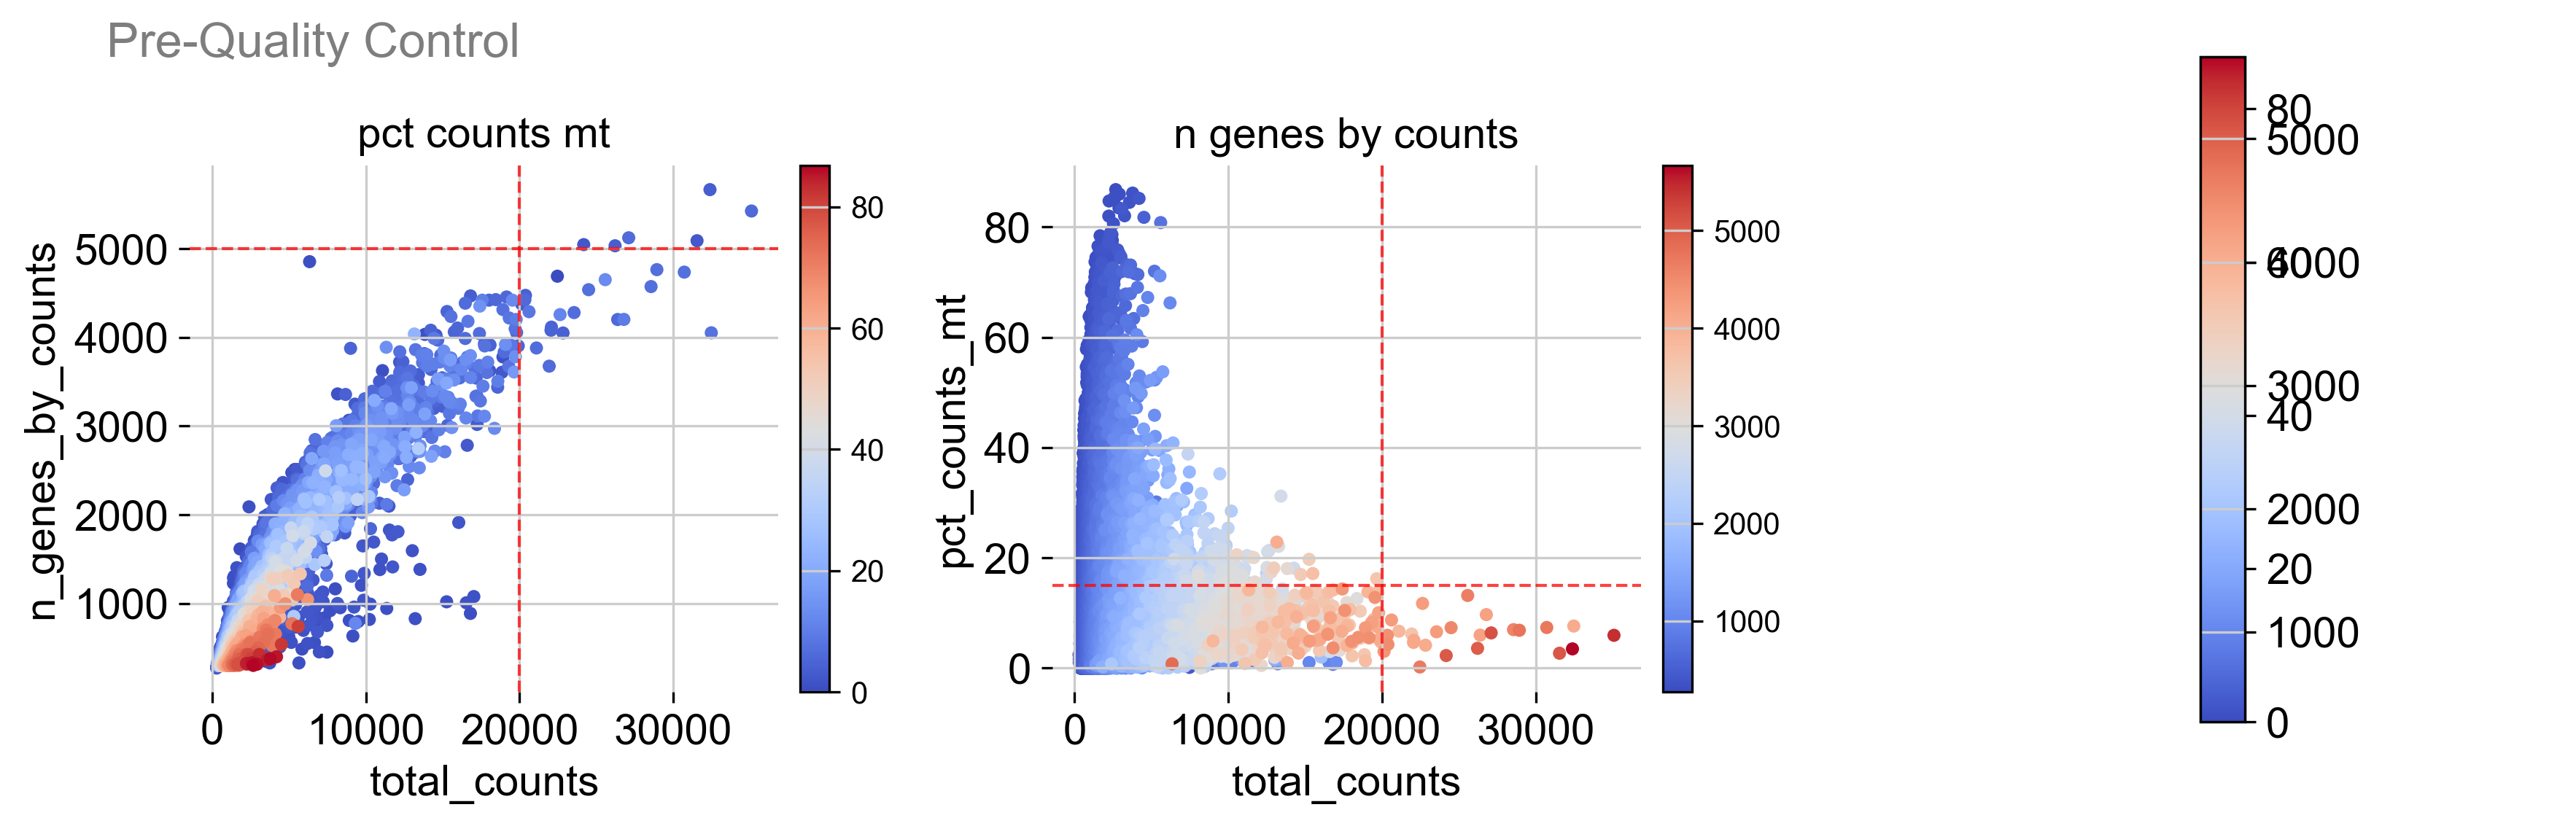

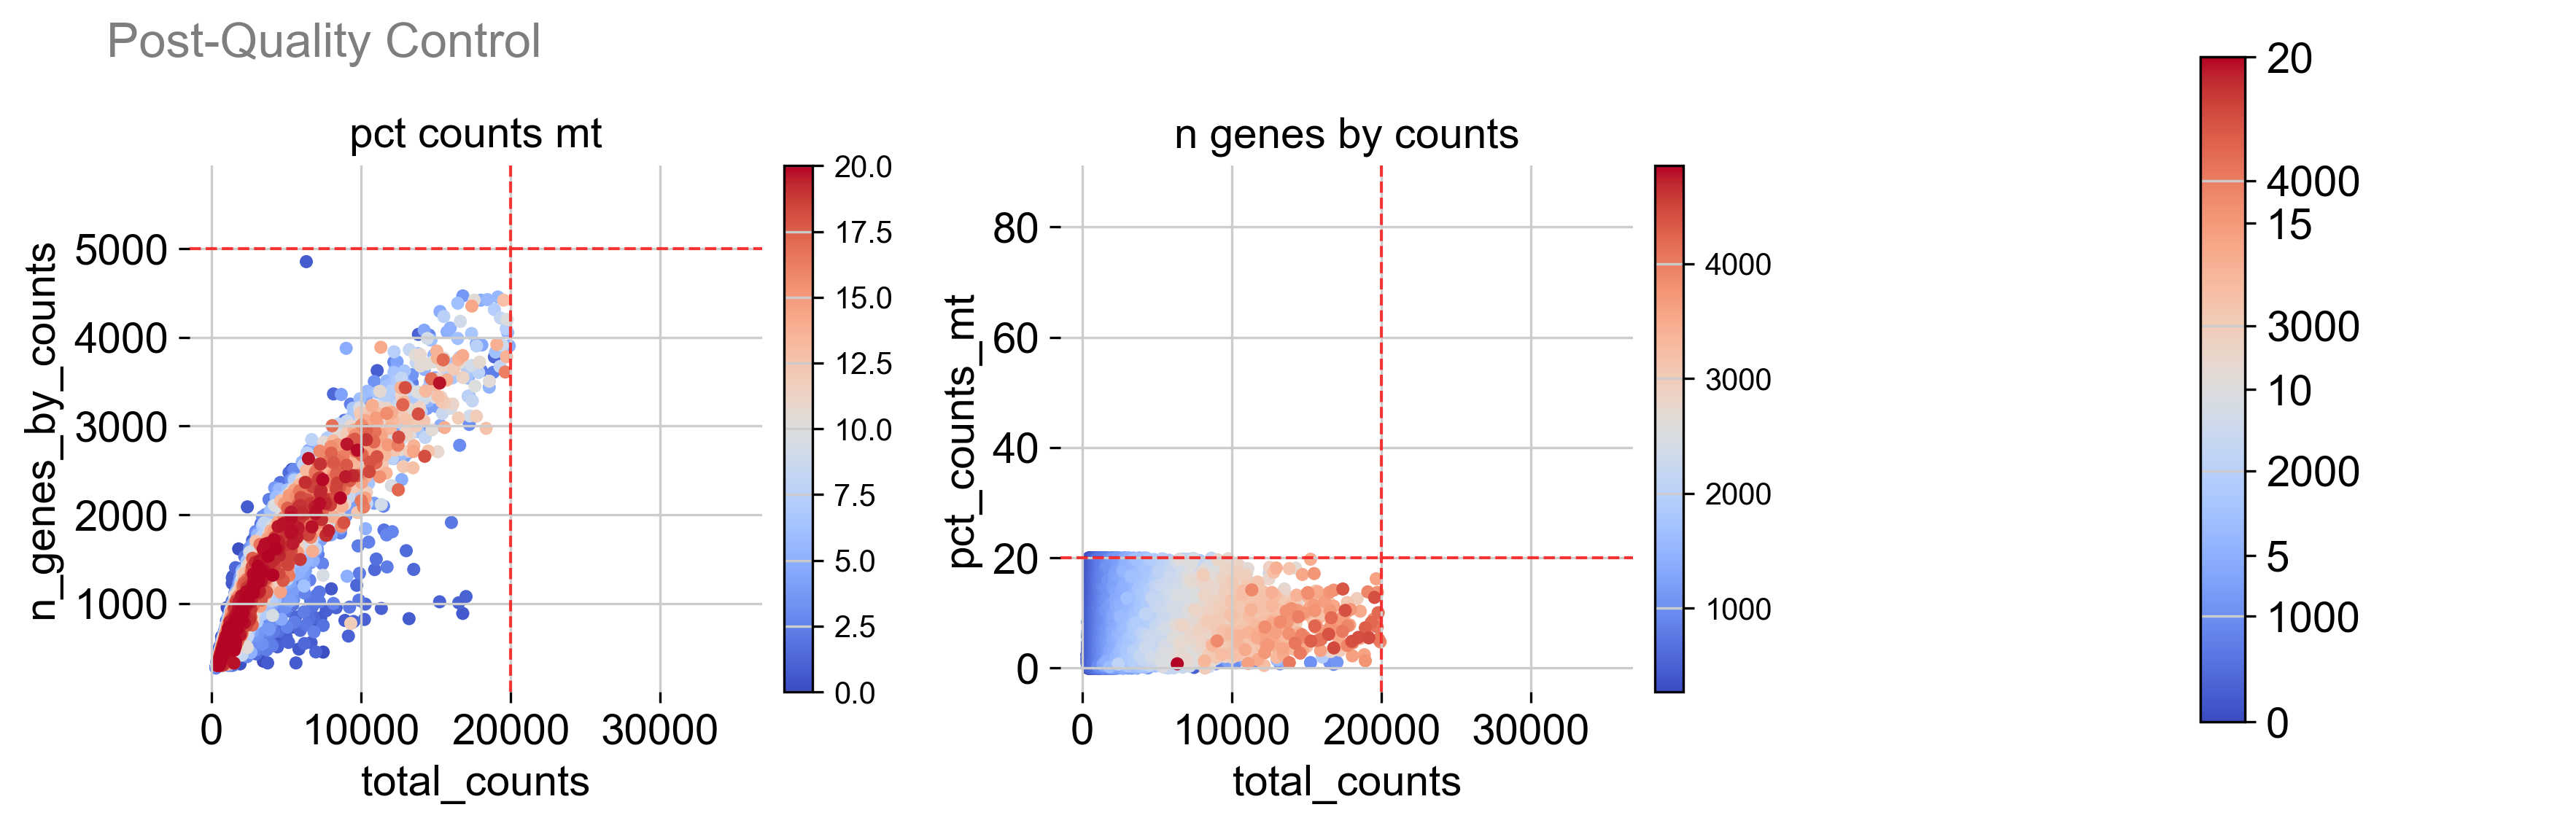

In [33]:
fig,(ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))
kws = {'size':75, 'show':False}
kws_lines = {"ls":"--", "alpha":0.75, "linewidth":1, 'color':"red"};
#         .         .         .         .         .         .         .         .         .         .         .         .
p1 = sc.pl.scatter(adata_wQC01, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt',     **kws, ax=ax1)
divider = make_axes_locatable(ax1); cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(ax1.collections[0], cax=cax)
cbar.ax.yaxis.set_label_position('right'); cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.tick_params(labelsize=10)
#         .         .         .         .         .         .         .         .         .         .         .         .
p2 = sc.pl.scatter(adata_wQC01, x='total_counts', y='pct_counts_mt',     color='n_genes_by_counts', **kws, ax=ax2)
divider = make_axes_locatable(ax2); cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(ax2.collections[0], cax=cax)
cbar.ax.yaxis.set_label_position('right'); cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.tick_params(labelsize=10)
#         .         .         .         .         .         .         .         .         .         .         .         .
p3 = plt.plot()
#         .         .         .         .         .         .         .         .         .         .         .         .
p1.axhline(y=5000, **kws_lines); p1.axvline(x=20000, **kws_lines)
p2.axhline(y=15,   **kws_lines); p2.axvline(x=20000, **kws_lines)
#         .         .         .         .         .         .         .         .         .         .         .         .
xlim1 = p1.get_xlim(); xlim2 = p2.get_xlim(); #xlim3 = p3.get_xlim()
ylim1 = p1.get_ylim(); ylim2 = p2.get_ylim(); #ylim3 = p3.get_ylim()
ax3.axes.xaxis.set_visible(False); ax3.axes.yaxis.set_visible(False); 
sns.despine(top=True, right=True, left=True, bottom=True)
plt.suptitle("Pre-Quality Control ", fontsize=16, color="#7E7E7E", ha='left', x=0.05, y=0.95)
plt.tight_layout()
#         .         .         .         .         .         .         .         .         .         .         .         .
fig,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))
p1 = sc.pl.scatter(adata_wQC, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt', **kws, ax=ax1)
divider = make_axes_locatable(ax1); cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(ax1.collections[0], cax=cax)
cbar.ax.yaxis.set_label_position('right'); cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.tick_params(labelsize=10)
#         .         .         .         .         .         .         .         .         .         .         .         .
p2 = sc.pl.scatter(adata_wQC, x='total_counts', y='pct_counts_mt',     color='n_genes_by_counts', **kws, ax=ax2)
divider = make_axes_locatable(ax2); cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(ax2.collections[0], cax=cax)
cbar.ax.yaxis.set_label_position('right'); cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.tick_params(labelsize=10)
#         .         .         .         .         .         .         .         .         .         .         .         .
p3 = plt.plot(); 
#         .         .         .         .         .         .         .         .         .         .         .         .
p1.axhline(y=5000, **kws_lines); p1.axvline(x=20000, **kws_lines)
p2.axhline(y=20,   **kws_lines); p2.axvline(x=20000, **kws_lines)
p1.set_ylim(ylim1); p1.set_xlim(xlim1); p2.set_ylim(ylim2); p2.set_xlim(xlim2); 
ax3.axes.xaxis.set_visible(False); ax3.axes.yaxis.set_visible(False); 
sns.despine(top=True, right=True, left=True, bottom=True)
plt.suptitle("Post-Quality Control ", fontsize=16, color="#7E7E7E", ha='left', x=0.05, y=0.95)
plt.tight_layout()

In [34]:
adata_wQC

AnnData object with n_obs × n_vars = 115633 × 24463
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ri', 'pct_counts_ri', 'total_counts_hb', 'pct_counts_hb', 'outlier_ngenes', 'outlier_total', 'outlier_hb', 'outlier_mt', 'outlier_ri'
    var: 'ensembl_id', 'gene_catg', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt', 'ri', 'hb'

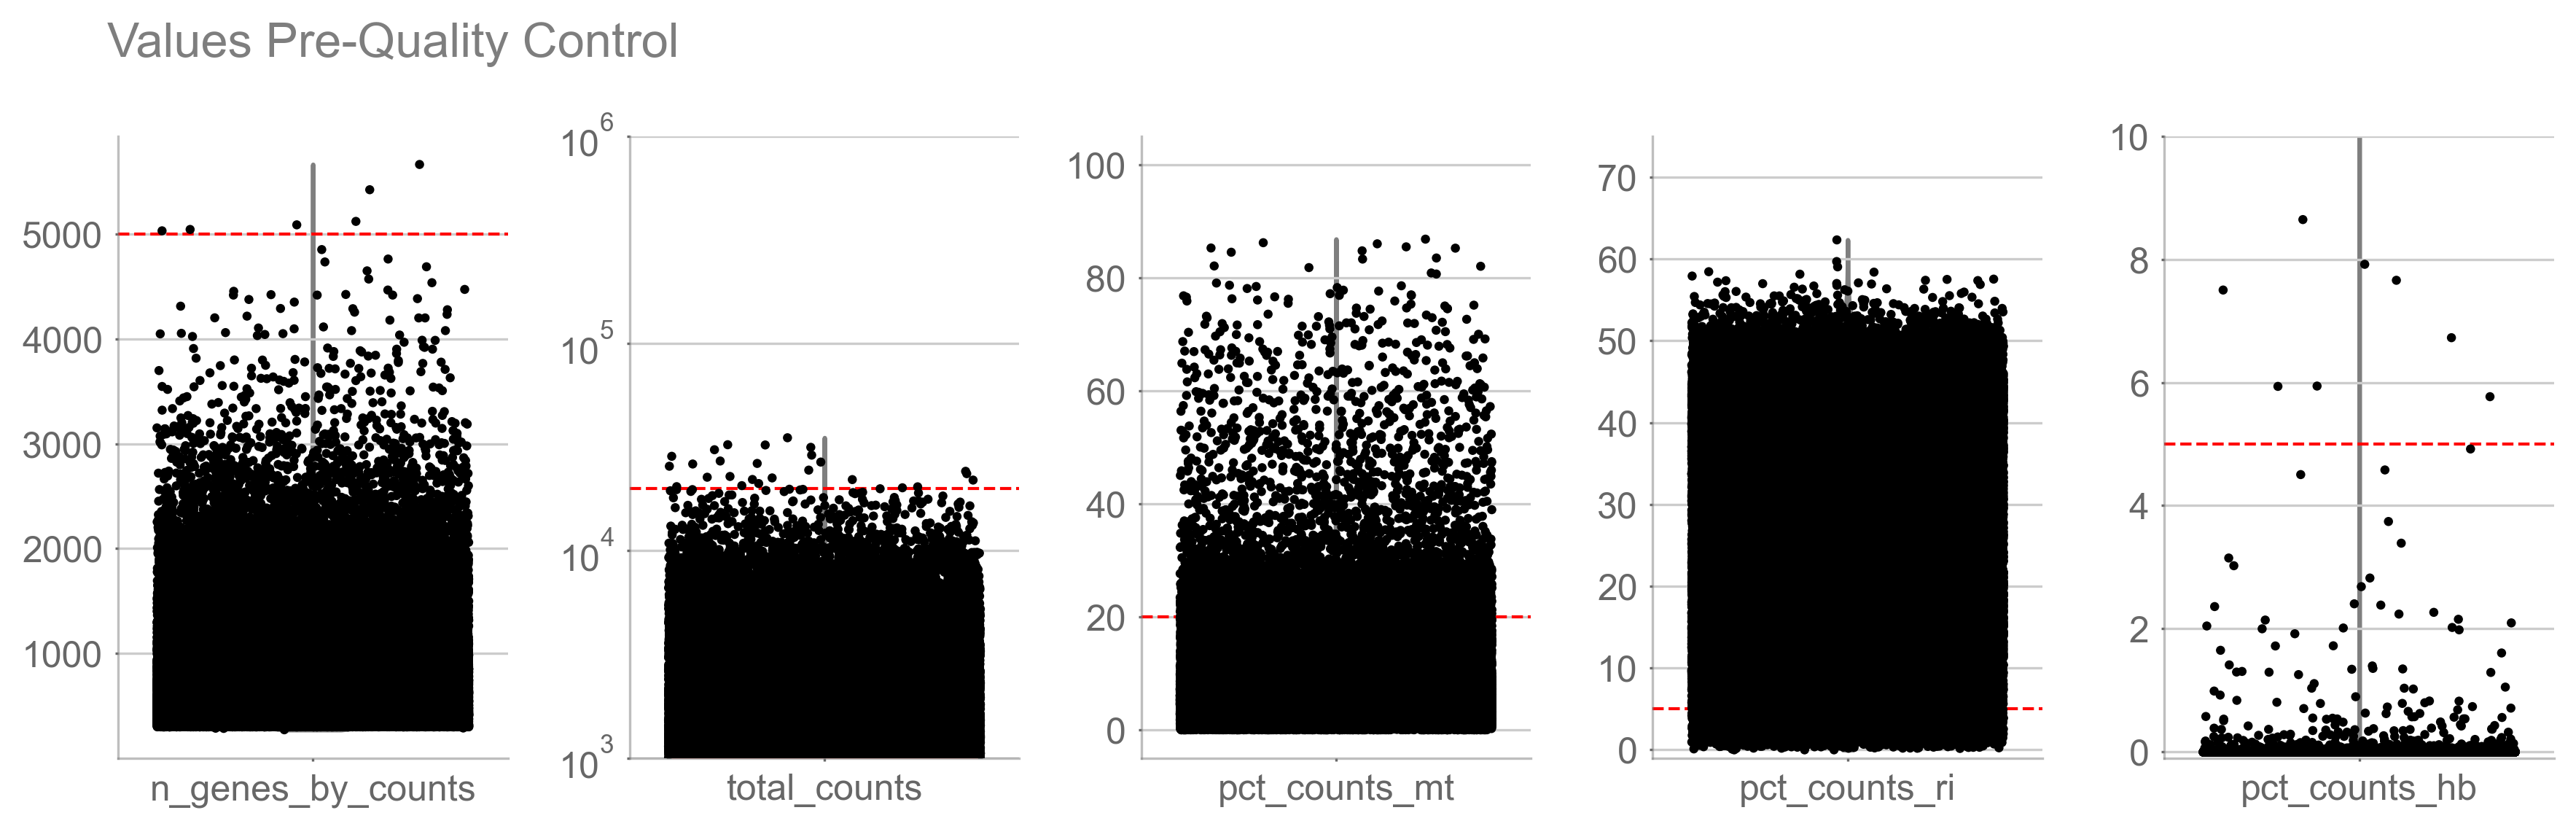

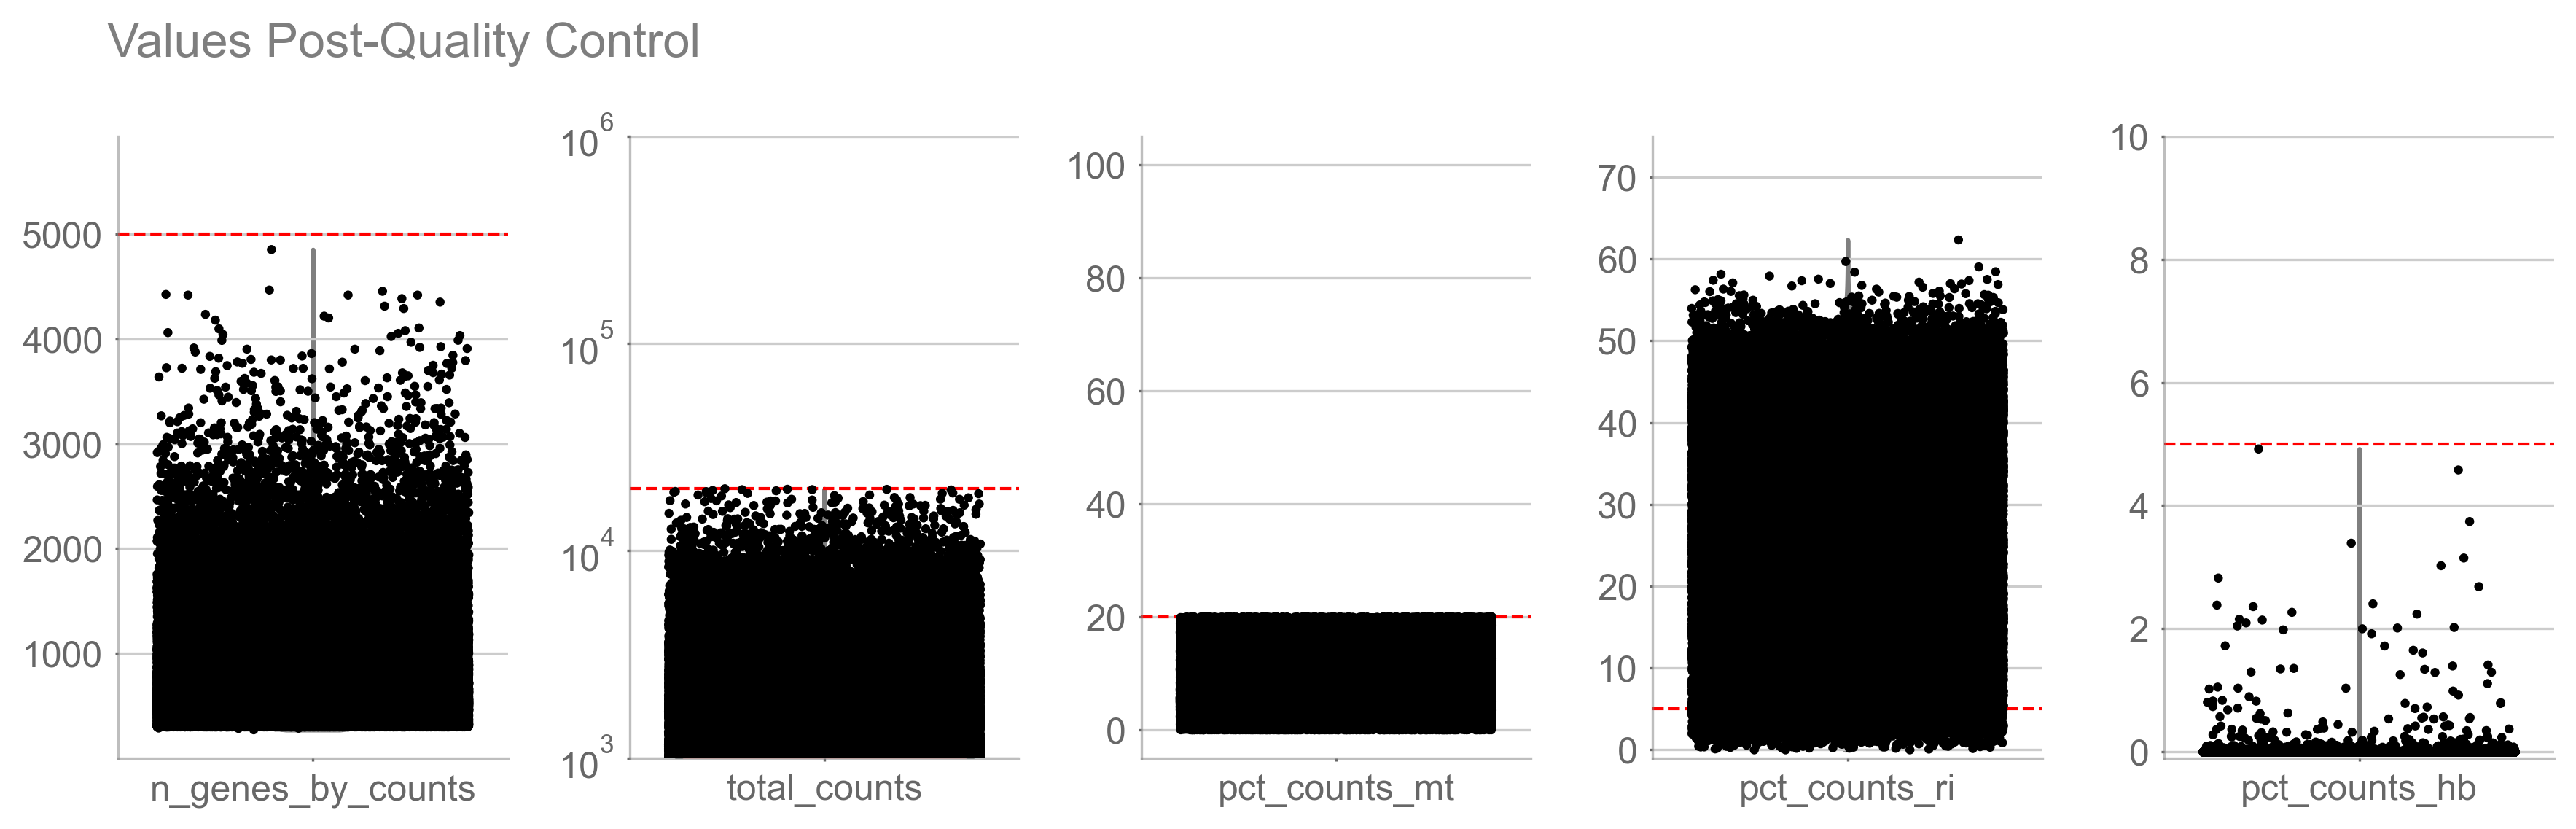

In [35]:
kws       = {'size':3, 'jitter':0.4, 'color':'#FF0000', 'palette':'Pastel1', 'show':False}
kws_l     = {"ls":"--", 'color':"red", "alpha":1, "linewidth":1};
tickp_kws = {'labelsize':12, 'colors':"#676767", 'pad':4, 'length':1};           
#         .         .         .         .         .         .         .         .         .         .         .         .
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize=(12,4)); plt.subplots_adjust(wspace=0, hspace=0)
p1 = sc.pl.violin(adata_wQC01, 'n_genes_by_counts', **kws, ax=ax1); ax2.set_yscale("symlog");
p2 = sc.pl.violin(adata_wQC01, 'total_counts',      **kws, ax=ax2); ax2.set_yscale("symlog"); ax2.set_ylim(1E3, 1E6)
p3 = sc.pl.violin(adata_wQC01, 'pct_counts_mt',     **kws, ax=ax3); ax3.set_yscale("linear"); ax3.set_ylim(-5, 105)
p4 = sc.pl.violin(adata_wQC01, 'pct_counts_ri',     **kws, ax=ax4); ax4.set_yscale("linear"); ax4.set_ylim(-1, 75)
p5 = sc.pl.violin(adata_wQC01, 'pct_counts_hb',     **kws, ax=ax5); ax5.set_yscale("linear"); ax5.set_ylim(-0.1, 10)
#         .         .         .         .         .         .         .         .         .         .         .         .
axes_y_values = [(p1, 5000), (p2, 20000), (p3, 20), (p4, 5), (p5, 5)]; axes_list = [p1, p2, p3, p4, p5]
#         .         .         .         .         .         .         .         .         .         .         .         .
for ax in axes_list:
    ax.tick_params(axis="x", **tickp_kws); ax.tick_params(axis="y", which='major', **tickp_kws)
    axlabelkws = {'fontsize':0}; ax.set_ylabel("", **axlabelkws)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False); ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color('#7E7E7E'); ax.spines[spine].set_alpha(0.5);
        ax.spines[spine].set_linewidth(0.8)
#         .         .         .         .         .         .         .         .         .         .         .         .
for ax, y_value in axes_y_values:
    ax.axhline(y=y_value, **kws_l)
#         .         .         .         .         .         .         .         .         .         .         .         .
plt.suptitle("Values Pre-Quality Control ", fontsize=16, color="#7E7E7E", ha='left', x=0.05, y=0.95)
ylim01 = p1.get_ylim(); ylim02 = p2.get_ylim(); ylim03 = p3.get_ylim(); ylim04 = p4.get_ylim(); ylim05 = p5.get_ylim();
plt.tight_layout(); plt.show()
#         .         .         .         .         .         .         .         .         .         .         .         .
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 5, figsize=(12,4)); plt.subplots_adjust(wspace=0, hspace=0)
p1 = sc.pl.violin(adata_wQC, 'n_genes_by_counts', **kws, ax=ax1); ax2.set_yscale("symlog"); ax2.set_ylim(ylim01)
p2 = sc.pl.violin(adata_wQC, 'total_counts',      **kws, ax=ax2); ax2.set_yscale("symlog"); ax2.set_ylim(ylim02)
p3 = sc.pl.violin(adata_wQC, 'pct_counts_mt',     **kws, ax=ax3); ax3.set_yscale("linear"); ax3.set_ylim(ylim03)
p4 = sc.pl.violin(adata_wQC, 'pct_counts_ri',     **kws, ax=ax4); ax4.set_yscale("linear"); ax4.set_ylim(ylim04)
p5 = sc.pl.violin(adata_wQC, 'pct_counts_hb',     **kws, ax=ax5); ax5.set_yscale("linear"); ax5.set_ylim(ylim05)
#         .         .         .         .         .         .         .         .         .         .         .         .
axes_y_values = [(p1, 5000), (p2, 20000), (p3, 20), (p4, 5), (p5, 5)]; axes_list = [p1, p2, p3, p4, p5]
#         .         .         .         .         .         .         .         .         .         .         .         .
for ax in axes_list:
    ax.tick_params(axis="x", **tickp_kws); ax.tick_params(axis="y", which='major', **tickp_kws)
    axlabelkws = {'fontsize':0}; ax.set_ylabel("", **axlabelkws)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False); ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:   
        ax.spines[spine].set_color('#7E7E7E'); ax.spines[spine].set_alpha(0.5);
        ax.spines[spine].set_linewidth(0.8)
#         .         .         .         .         .         .         .         .         .         .         .         .
for ax, y_value in axes_y_values:
    ax.axhline(y=y_value, **kws_l)
plt.ylabel('', fontsize=0, color="#7E7E7E", labelpad=5)
#         .         .         .         .         .         .         .         .         .         .         .         .
plt.suptitle("Values Post-Quality Control ", fontsize=16, color="#7E7E7E", ha='left', x=0.05, y=0.95)
p1.set_ylim(ylim01);  p2.set_ylim(ylim02)
plt.tight_layout(); plt.show()

In [36]:
norm_data = adata_wQC.copy()
del adata_wQC; gc.collect()       # Delete df and force garbage collection to release memory
sc.pp.normalize_total(norm_data, target_sum=1e4)
sc.pp.log1p(norm_data)

In [37]:
# This code performs a process to identify highly variable genes (HVGs) in a single-cell RNA sequencing (scRNA-seq) dataset.
HVG_data = norm_data.copy()
del norm_data; gc.collect()      # Delete df and force garbage collection to release memory
sc.pp.highly_variable_genes(HVG_data, min_mean=0.0125, max_mean=3, min_disp=0.5)
#sc.pl.highly_variable_genes(adata, save='') # scanpy generates the filename automatically
HVG_data.var['highly_variable']

AL627309.1    False
AL627309.5     True
AP006222.2    False
LINC01409     False
FAM87B        False
              ...  
AC004556.3    False
AC233755.2    False
AC233755.1     True
AC007325.4    False
AC007325.2    False
Name: highly_variable, Length: 24463, dtype: bool

In [38]:
HVG_data

AnnData object with n_obs × n_vars = 115633 × 24463
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ri', 'pct_counts_ri', 'total_counts_hb', 'pct_counts_hb', 'outlier_ngenes', 'outlier_total', 'outlier_hb', 'outlier_mt', 'outlier_ri'
    var: 'ensembl_id', 'gene_catg', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt', 'ri', 'hb', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

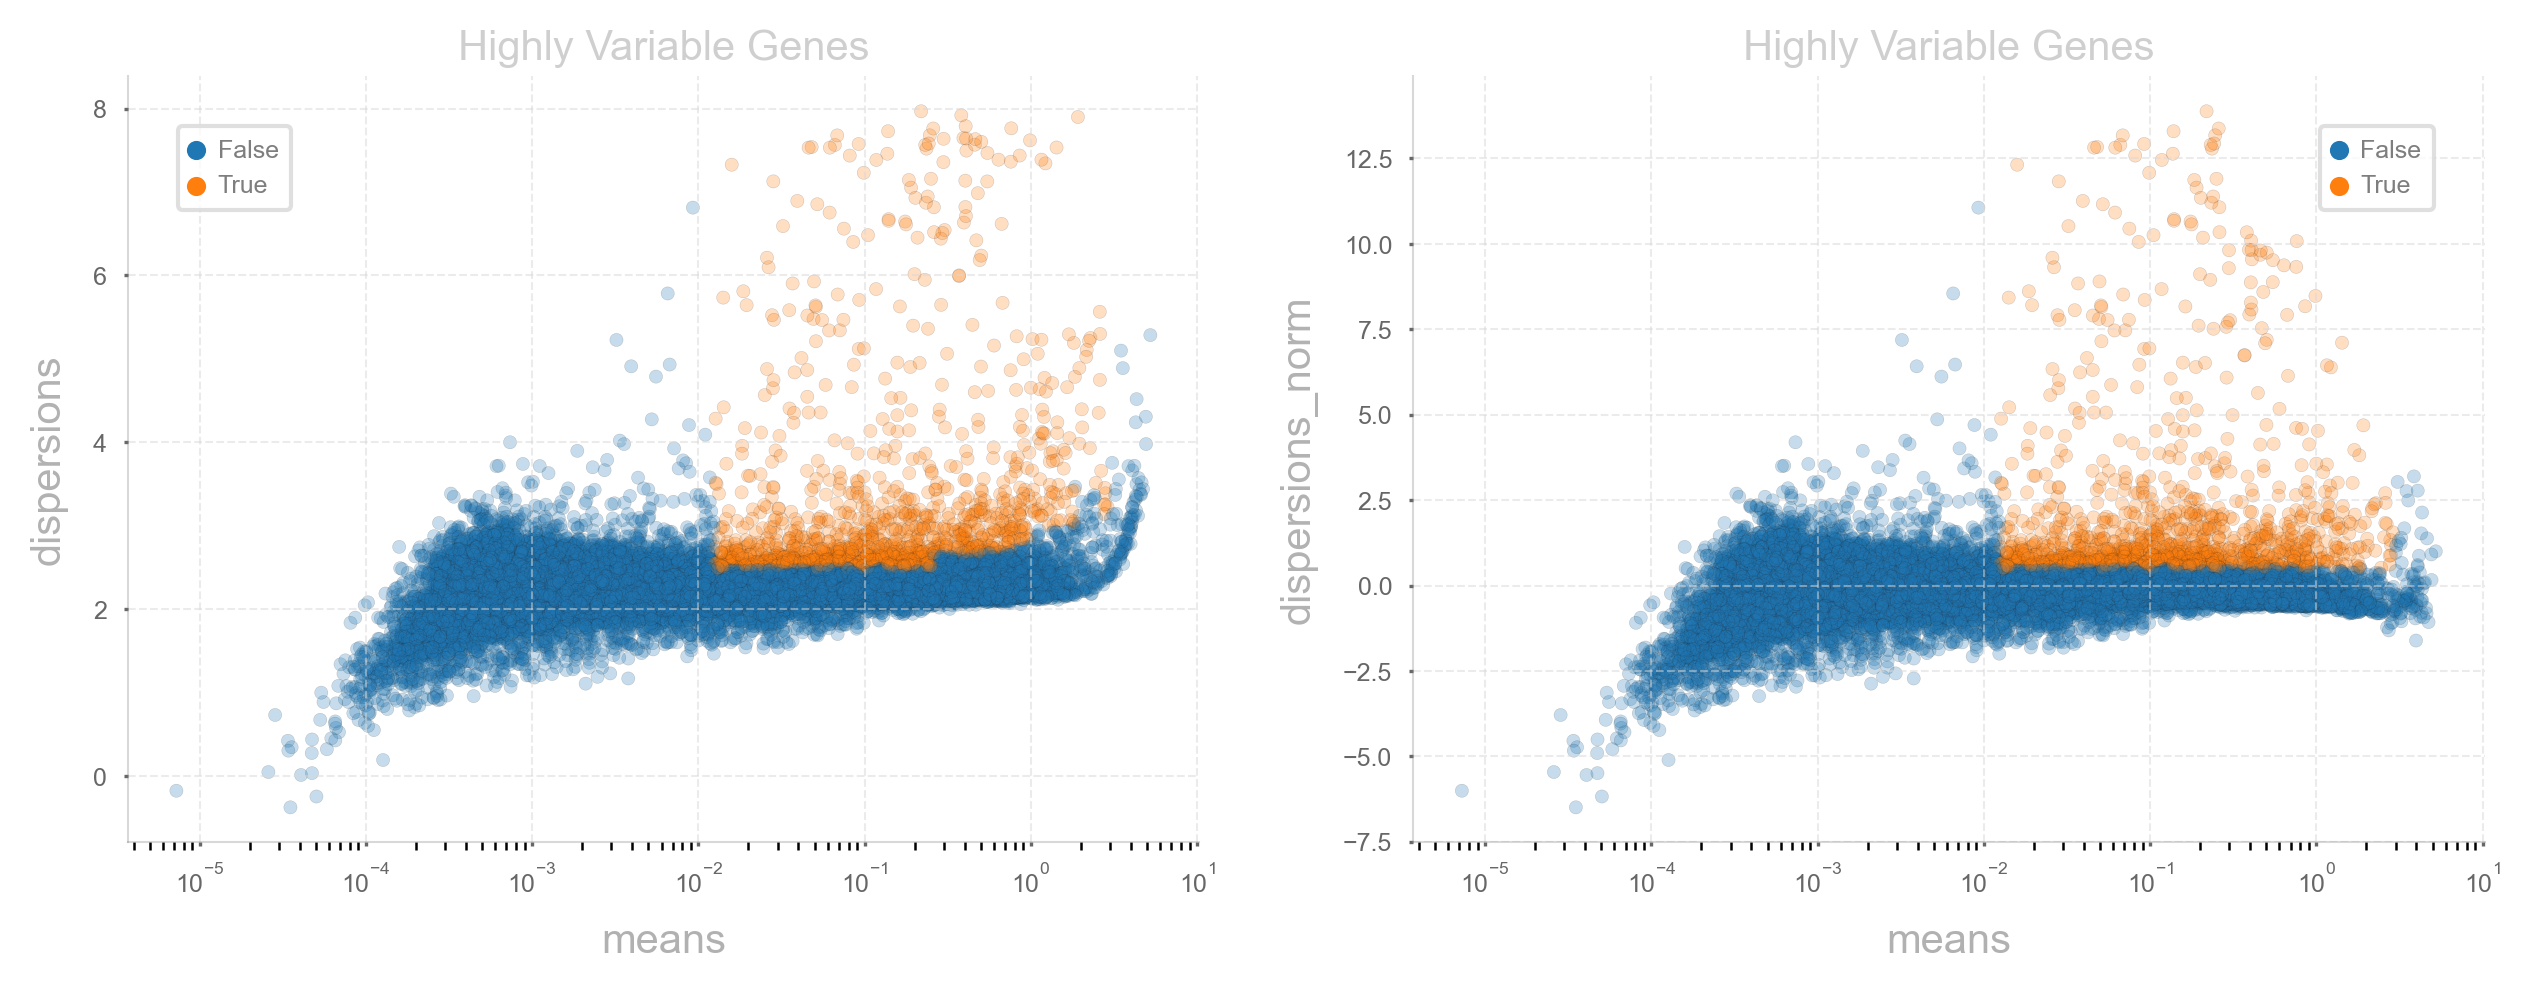

In [39]:
#         .         .         .         .         .         .         .         .         .         .         .         .
#HVG_data.var["highly_variable2"] = HVG_data.var["highly_variable"].astype(bool).astype(str)
var_df = pd.DataFrame(HVG_data.var); figsize=(22/2.54, 9/2.54)

#         .         .         .         .         .         .         .         .         .         .         .         .
x = "means";  y1 = "dispersions"; y2 = "dispersions_norm"; color = "highly_variable"; 
texts01 = []; texts02 = [];
#         .         .         .         .         .         .         .         .         .         .         .         .
genes = [    'HILPDA', 'CD83',    'S100A9',  'SAMSN1',     'CREM',      'LTB',   'TMEM158',
             'BNIP3',  'IER2',    'FCER1G',   'STAT1',  'TWISTNB',      'BLK',     'JOSD2',
             'DUSP2',  'SKIL',  'C15orf48',    'GBP1',     'WARS',  'SMARCB1',  'NDUFA4L2',   ]
#         .         .         .         .         .         .         .         .         .         .         .         .
fig, (ax1, ax2) = plt.subplots(1,2, figsize=figsize, dpi=150)
kws1 = {'s':10, 'alpha':0.25, 'linewidth':0.1,'edgecolor':'#1E1E1E', }
p1 = sns.scatterplot(data=var_df, x=x, y=y1, hue=color, **kws1, ax=ax1)
p2 = sns.scatterplot(data=var_df, x=x, y=y2, hue=color, **kws1, ax=ax2)
#         .         .         .         .         .         .         .         .         .         .         .         .
p1.set_xscale('log'); p2.set_xscale('log');
#         .         .         .         .         .         .         .         .         .         .         .         .
grid_kws = {'color':'#d8d8d8', 'linestyle':'dashed', 'linewidth':0.5, 'alpha':0.5}
ax1.xaxis.grid(**grid_kws); ax1.yaxis.grid(**grid_kws); 
ax2.xaxis.grid(**grid_kws); ax2.yaxis.grid(**grid_kws)
#         .         .         .         .         .         .         .         .         .         .         .         .
axlabelkws = {'fontsize':10, 'color':'#7E7E7E', 'alpha':0.6, 'labelpad':6}
ax1.set_xlabel(x, **axlabelkws); ax1.set_ylabel(y1, **axlabelkws)
ax2.set_xlabel(x, **axlabelkws); ax2.set_ylabel(y2, **axlabelkws)
#         .         .         .         .         .         .         .         .         .         .         .         .
for spine in ['top', 'right']:
    ax1.spines[spine].set_visible(False); ax2.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax1.spines[spine].set_color('#7E7E7E'); ax1.spines[spine].set_alpha(0.3); ax1.spines[spine].set_linewidth(0.5)
    ax2.spines[spine].set_color('#7E7E7E'); ax2.spines[spine].set_alpha(0.3); ax2.spines[spine].set_linewidth(0.5)
#         .         .         .         .         .         .         .         .         .         .         .         .
title_kws ={'fontsize':10, 'color':"#cfcfcf", 'pad':4}
ax1.set_title("Highly Variable Genes", **title_kws); ax2.set_title("Highly Variable Genes", **title_kws); 
#         .         .         .         .         .         .         .         .         .         .         .         .       
tickp_kws = {'labelsize':6, 'colors':"#676767", 'pad':4, 'length':1}
p1.tick_params(axis="x", **tickp_kws); p1.tick_params(axis="y", which='major', **tickp_kws)
p2.tick_params(axis="x", **tickp_kws); p2.tick_params(axis="y", which='major', **tickp_kws)
#         .         .         .         .         .         .         .         .         .         .         .         .
#x = var_df['means'].values; y1 = var_df['dispersions'].values; y2 = var_df['dispersions_norm'].values
#for i, txt in enumerate(genes):
#    annkws = {'xytext':figsize, 'textcoords':'offset points', 'fontsize':5, 'weight':500, 'color':"#000000",}
#    ax1.annotate(txt, (x[i], y1[i]), **annkws); ax2.annotate(txt, (x[i], y2[i]), **annkws)
#         .         .         .         .         .         .         .         .         .         .         .         .
handles, labels = ax1.get_legend_handles_labels();
l_kws = {'fontsize':6, 'labelcolor':"#7E7E7E", 'markerscale':0.6, 'markerfirst':'True', 'handletextpad':0.6, 
         'loc':2, 'borderaxespad':2, 'borderpad':0.5, 'facecolor':"white", 'edgecolor':"#d8d8d8", 'frameon':True}
p1.legend(handles[0:2],labels[0:2], bbox_to_anchor=(0.00, 1), **l_kws)
p2.legend(handles[0:2],labels[0:2], bbox_to_anchor=(0.80, 1), **l_kws)
#         .         .         .         .         .         .         .         .         .         .         .         .
#p1.legend([],[],frameon=False); p2.legend([],[],frameon=False)
#         .         .         .         .         .         .         .         .         .         .         .         .
plt.tight_layout()

In [40]:
# filter the gene expression matrix in the HVG data structure to include only genes with high variability.
HVG_data = HVG_data[:, HVG_data.var.highly_variable]

In [41]:
HVG_data.var.columns = HVG_data.var.columns.astype(str) # Ensure all column names are strings

In [44]:
HVG_data

View of AnnData object with n_obs × n_vars = 115633 × 1460
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ri', 'pct_counts_ri', 'total_counts_hb', 'pct_counts_hb', 'outlier_ngenes', 'outlier_total', 'outlier_hb', 'outlier_mt', 'outlier_ri'
    var: 'ensembl_id', 'gene_catg', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt', 'ri', 'hb', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [45]:
a, b = HVG_data.shape
print("Remaining cells:\t {}".format(HVG_data.n_obs), '\n')


Cells Pre-filter:	 115633
Remaining cells:	 115633 



In [ ]:
#HVG_data.write(HVG_h5ad_file_path)

In [42]:
# Path to your audio file
audio_file = "../../data/clock-chime-88027.mp3"
display(Audio(audio_file, autoplay=True))

In [43]:
print("'GSE279781_01.Preproc_v01' script run time:", f'{time.time()-code_start:.0f}', "seconds.")

'GSE279781_01.Preproc_v01' script run time: 193 seconds.
